## Import Libraries and Load Data

In [1]:
# change to home directory first, to load environment variables from .env file
%cd /home/josh/Code/reqqit

# verify access via reddit api (using praw library)
from reddit import access_read_only
access_read_only()

/home/josh/Code/reqqit


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
'''
    load corpus (reddit posts)
'''

def load_csv(path: str, separator='~'):
    return pd.read_csv(path, header=0, sep=separator, encoding='utf-8', index_col=0)

import os
from settings_reqqit import DATASETS_PATH

# define paths to datasets
path_all = os.path.join(DATASETS_PATH, 'm', 'all.jobs.~.csv')
path_positive = os.path.join(DATASETS_PATH, 'm', 'samples.positive.jobs.tsv')

# combine positive training examples and all jobs
df_pos = load_csv(path_positive, separator='\t')
df_all = load_csv(path_all)


df = pd.concat([df_pos, df_all])

# try using only positive samples to build Word2Vec model
# df = df_pos

# reindex on id column
df.set_index(df.id, inplace=True)

Let's take a quick look at our data.

In [4]:
df

score      id                                              title  \
id                                                                         
jvnuvh      1  jvnuvh             [Hiring] 3D Computer Vision Researcher   
jr2pc6      1  jr2pc6       [Hiring] Applied Scientist - Computer Vision   
jn91q1      1  jn91q1    [Hiring] Senior Software Engineer, Data Science   
jnb3mt      1  jnb3mt  [HIRING] AI/ML- Machine Learning Engineer at A...   
jnbq0r      1  jnbq0r  [Hiring] Senior Software Engineer - Machine Le...   
...       ...     ...                                                ...   
d52uqv      1  d52uqv  [HIRING][REMOTE]Principal Python Software Engi...   
d51udt      1  d51udt  [HIRING][REMOTE] 130000 USD - Senior Python En...   
d3uw0s      1  d3uw0s  [HIRING][REMOTE]Intermediate/Senior Software Q...   
d3riw8      1  d3riw8      [HIRING][REMOTE]Scientific Software Developer   
d3m3qm      1  d3m3qm     [HIRING][REMOTE]Junior Developer @ Self Decode   

                                                 selftext  \
id                                                          
jvnuvh                                                NaN   
jr2pc6                                                NaN   
jn91q1                                                NaN   
jnb3mt                                                NaN   
jnbq0r                                                NaN   
...                                                   ...   
d52uqv  What kind of candidates do we need?\n\n **Tool...   
d51udt  We are hiring! Pay scales with experience. Fin...   
d3uw0s  What kind of candidates do we need?\n\n **Tool...   
d3riw8  What kind of candidates do we need?\n\n **Lang...   
d3m3qm  What kind of candidates do we need?\n\n **Tool...   

                                                      url  url_content  
id                                                                      
jvnuvh  https://ai-jobs.net/job/3985-3d-computer-visio...          NaN  
jr2pc6  https://ai-jobs.net/job/3882-applied-scientist...          NaN  
jn91q1  https://ai-jobs.net/job/3782-senior-software-e...          NaN  
jnb3mt  https://aijobs.com/jobs/ai-ml-machine-learning...          NaN  
jnbq0r  https://ai-jobs.net/job/3783-senior-software-e...          NaN  
...                                                   ...          ...  
d52uqv  https://www.reddit.com/r/remotepython/comments...          NaN  
d51udt  https://www.reddit.com/r/remotepython/comments...          NaN  
d3uw0s  https://www.reddit.com/r/remotepython/comments...          NaN  
d3riw8  https://www.reddit.com/r/remotepython/comments...          NaN  
d3m3qm  https://www.reddit.com/r/remotepython/comments...          NaN  

[7070 rows x 6 columns]

Given below is the description of the fields in this dataset:

1. __score:__ reddit score, aggregate of upvotes and downvotes.

2. __id:__ reddit post id (unique).

3. __title:__ Title of post

4. __selftext:__ Accompanying text that describes the post (optional).

5. __url:__ Link to external job posting (optional).

6. __url_content:__ When provided, scraped HTML content of link (optional).

## Treat Missing Data

In [5]:
# check for missing values
df.isnull().sum()

score             0
id                0
title             0
selftext       3065
url               0
url_content    7070
dtype: int64

## Data Preparation

Let's convert the `title` to string datatype.

In [6]:
df.title = df.title.astype(str)

## Build word2vec Embeddings

In [7]:
from recommenders.word2vec import build_word2vec_model
MIN_COUNT = 60
model = build_word2vec_model(corpus=df.title.tolist(),
                             word2vec_kwargs={'min_count': MIN_COUNT, 'vector_size': 30},
                             bigrams_kwargs={'min_count': MIN_COUNT})

As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient.

In [8]:
model.init_sims(replace=True)

Now we will extract the vectors of all the words in our vocabulary and store it in one place for easy access.

In [9]:
model_vocab = list(model.wv.key_to_index)
print(len(model_vocab), model_vocab)
X = model.wv[model_vocab]

94 ['hiring', 'remote', 'data', 'engineer', 'machine_learning', 'developer', 'scientist', 'senior', 'jobs', 'science', 'software', 'job', 'hire', 'new', 'python', 'stack', 'web', 'work', 'engineering', 'react', 'usd', 'analyst', 'looking', 'javascript', 'research', 'ai', 'internship', 'time', 'analytics', 'ml', 'allows', 'big', 'development', 'manager', 'end', 'ca', 'new_york', 'positions', 'sr', 'learning', 'django', 'vision', 'united_states', 'lead', 'san_francisco', 'deep', 'js', 'london', 'year', 'intern', 'backend', 'experience', 'california', 'application', 'team', 'usa', 'node_js', 'php', 'openings', 'security', 'ny', 'intelligence', 'design', 'united_nations', 'vue_js', 'platform', 'frontend', 'companies', 'specialist', 'level', 'architect', 'ruby', 'principal', 'list', 'junior', 'nlp', 'aws', 'uk', 'help', 'tech', 'contract', 'open', 'product', 'interview', 'rails', 'applied', 'position', 'remotely', 'canada', 'home', 'staff', 'devops', 'business', 'need']


## Visualize word2vec Embeddings

In [10]:
# create vectors from training data
from recommenders.word2vec import create_vectors, visualize_vectors
X, filtered_ids = create_vectors(df.title.tolist(), df, model)
upper_limit = min(400, len(df))
visualize_vectors(X, df, titles_to_plot=list(np.arange(0, upper_limit, upper_limit // 10)))

155 docs removed
0 docs removed


### Visualize positive training samples vector representations within universe of embeddings

In [11]:
import os

# load positive training samples (saved posts)
df_saved = load_csv(os.path.join(DATASETS_PATH, 'm', 'samples.positive.jobs.tsv'), separator='\t')

# create vectors for saved posts
X_saved, filtered_ids = create_vectors(df_saved.title.tolist(), df_saved, model)

# concat saved posts with training vectors
X_concat = np.vstack([X_saved, X])

# plot vectors
visualize_vectors(X, df_pos, list(np.arange(0, len(df_pos) - 1, 5)))

0 docs removed
0 docs removed


# Create balanced training and testing datasets for ML models (binary classification)

In [12]:
import dataset
X_positive, X_negative = dataset.jobs_training_data(model)

# display counts
counts = {
    'positive samples': len(X_positive),
    'negative samples': len(X_negative)
}
print(counts)

0 docs removed
0 docs removed
7 docs removed
0 docs removed
{'positive samples': 92, 'negative samples': 92}


In [13]:
# create training and test splits
X_train, X_test, y_train, y_test = dataset.train_test_split(X_negative, X_positive)

# display counts
counts = {
    'X_train samples': len(X_train),
    'y_train samples': len(y_train),
    'X_test samples': len(X_test),
    'y_test samples': len(y_test),
}
print(counts)

{'X_train samples': 128, 'y_train samples': 128, 'X_test samples': 56, 'y_test samples': 56}


## Train ML model: Random Forest Classifier

Test Accuracy: 	 0.9107142857142857
{'positive': {'precision': 0.9642857142857143, 'recall': 0.8709677419354839, 'f1-score': 0.9152542372881356, 'support': 31}, 'negative': {'precision': 0.8571428571428571, 'recall': 0.96, 'f1-score': 0.9056603773584904, 'support': 25}, 'accuracy': 0.9107142857142857, 'macro avg': {'precision': 0.9107142857142857, 'recall': 0.915483870967742, 'f1-score': 0.910457307323313, 'support': 56}, 'weighted avg': {'precision': 0.9164540816326531, 'recall': 0.9107142857142857, 'f1-score': 0.9109712641052583, 'support': 56}}


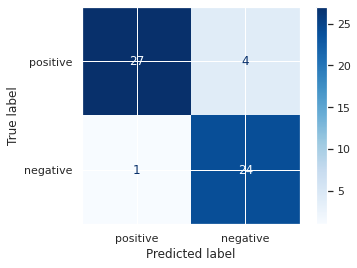

In [14]:
# train classifier: Random Forest
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=15, max_depth=5, random_state=1326)
clf_rf.fit(X_train, y_train)

# evaluate classifier's performance
y_pred = clf_rf.predict(X_test)
from recommenders.recommender import evaluate_performance
evaluate_performance(y_pred, y_test)

## Train classifier: Gradient Boosting Ensemble

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gb = GradientBoostingClassifier(n_estimators=13, max_depth=1, random_state=1326)
clf_gb.fit(X_train, y_train)

# evaluate classifier's performance
y_pred = clf_gb.predict(X_test)
from recommenders.recommender import evaluate_performance
evaluate_performance(y_pred, y_test)

Test Accuracy: 	 0.875
{'positive': {'precision': 0.9285714285714286, 'recall': 0.8387096774193549, 'f1-score': 0.8813559322033899, 'support': 31}, 'negative': {'precision': 0.8214285714285714, 'recall': 0.92, 'f1-score': 0.8679245283018867, 'support': 25}, 'accuracy': 0.875, 'macro avg': {'precision': 0.875, 'recall': 0.8793548387096775, 'f1-score': 0.8746402302526384, 'support': 56}, 'weighted avg': {'precision': 0.8807397959183673, 'recall': 0.875, 'f1-score': 0.8753597697473616, 'support': 56}}


# Fetch data from Reddit API to make predictions on recent posts

In [16]:
'''
    get recent data from reddit to create dataset/dataframe on which to make predictions
'''

from reddit import multireddits
from dataset import generate_dataset

# get 'jobs' multireddits
m_jobs, = multireddits(['jobs'])

# get top posts from multireddit within time period and limit
posts = m_jobs.top('week', limit=None)

# create a dataset from those posts
df_reddit = generate_dataset(posts)
df_reddit

score      id  \
2022-04-03 19:04:13     25  tvqel5   
2022-03-30 23:19:03     12  tstg8y   
2022-04-05 12:38:06     12  tx34lg   
2022-04-01 11:03:11     11  ttx8wp   
2022-04-05 10:03:01      8  twznik   
...                    ...     ...   
2022-04-06 03:55:36      0  txjg8d   
2022-04-04 06:08:13      0  tw1ln4   
2022-04-03 14:08:02      0  tvk040   
2022-04-02 08:04:51      0  tukxah   
2022-04-06 09:36:24      0  txqa0s   

                                                                 title  \
2022-04-03 19:04:13  How is everyone managing to find remote jobs? ...   
2022-03-30 23:19:03  what are the best companies to work for remotely?   
2022-04-05 12:38:06  Full time, remote, full-stack engineers w/ JS,...   
2022-04-01 11:03:11  Anything part-time, remote, and entry-level be...   
2022-04-05 10:03:01                         Worldwide and disheartened   
...                                                                ...   
2022-04-06 03:55:36              [HIRING] Blockchain Engineer at Block   
2022-04-04 06:08:13  I will mentor you and help (or start) your dro...   
2022-04-03 14:08:02            Negotiating Salary for a Remote USA Job   
2022-04-02 08:04:51  [Hiring] Solidity developer - NFT/Token Stakin...   
2022-04-06 09:36:24  [HIRING] Intermediate Level Python Developer W...   

                                                              selftext  \
2022-04-03 19:04:13                                                      
2022-03-30 23:19:03                                                      
2022-04-05 12:38:06  Full Time | Full-stack software engineers and ...   
2022-04-01 11:03:11  It seems like that's the only available option...   
2022-04-05 10:03:01  Hey everyone,\n\nI've been looking for a work ...   
...                                                                ...   
2022-04-06 03:55:36                                                      
2022-04-04 06:08:13  Hey guys, For some time now I’ve been trying t...   
2022-04-03 14:08:02  I am currently in the middle of salary/compens...   
2022-04-02 08:04:51                                                      
2022-04-06 09:36:24   Looking for Python developer to create an ant...   

                                                                   url  \
2022-04-03 19:04:13  https://www.reddit.com/r/RemoteJobs/comments/t...   
2022-03-30 23:19:03  https://www.reddit.com/r/RemoteJobs/comments/t...   
2022-04-05 12:38:06  https://www.reddit.com/r/remotejs/comments/tx3...   
2022-04-01 11:03:11  https://www.reddit.com/r/RemoteJobs/comments/t...   
2022-04-05 10:03:01  https://www.reddit.com/r/RemoteJobs/comments/t...   
...                                                                ...   
2022-04-06 03:55:36  https://crypto.jobs/jobs/blockchain-engineer-a...   
2022-04-04 06:08:13  https://www.reddit.com/r/RemoteJobs/comments/t...   
2022-04-03 14:08:02  https://www.reddit.com/r/RemoteJobs/comments/t...   
2022-04-02 08:04:51  https://crypto.jobs/jobs/solidity-developer-nf...   
2022-04-06 09:36:24  https://www.reddit.com/r/PythonJobs/comments/t...   

                    url_content  
2022-04-03 19:04:13              
2022-03-30 23:19:03              
2022-04-05 12:38:06              
2022-04-01 11:03:11              
2022-04-05 10:03:01              
...                         ...  
2022-04-06 03:55:36              
2022-04-04 06:08:13              
2022-04-03 14:08:02              
2022-04-02 08:04:51              
2022-04-06 09:36:24              

[205 rows x 6 columns]

# Make predictions on recent reddit data using classifier: Random Forest Ensemble

In [17]:
# make predictions from Reddit posts
from recommenders.recommender import recommend, SklearnWord2Vec
df_pred = recommend(SklearnWord2Vec(clf_rf, model), df_reddit)
df_pred

5 docs removed
0 docs removed
0 docs removed
0 docs removed


y_pred    y_prob                                              title  \
99     1.0       1.0  [Hiring] Machine learning job: Sr. Software En...   
185    1.0       1.0  [HIRING] Remote Machine learning job: Senior C...   
147    1.0  0.994872  [HIRING] Remote Machine learning job: Senior M...   
37     1.0  0.994872  [Hiring] Remote Machine learning job: Senior M...   
133    1.0  0.991538  [HIRING] Director, Applied Mathematics & Compu...   
..     ...       ...                                                ...   
35     0.0       0.0                                   Remote jobs help   
89     0.0       0.0   [HIRING] 2 new remote jobs at the United Nations   
173    0.0       0.0  [HIRING] New Remote Jobs in the Health Technol...   
176    0.0       0.0                                 EPAM ANYWHERE JOBS   
162    0.0       0.0  [HIRING] New Remote Jobs in the Health Technol...   

         id  
99   tupsrh  
185  tvjvo8  
147  tx2c2f  
37   tvgddd  
133  tsxflr  
..      ...  
35   tvv3lg  
89   tvuxzs  
173  tto6vr  
176  ttb8ai  
162  tv6zjb  

[200 rows x 4 columns]

# Make predictions on recent reddit data using classifier: Gradient Boosting Ensemble

In [18]:
from recommenders.recommender import recommend, SklearnWord2Vec
df_pred = recommend(SklearnWord2Vec(clf_gb, model), df_reddit)
df_pred

5 docs removed
0 docs removed
0 docs removed
0 docs removed


y_pred    y_prob                                              title  \
25     1.0  0.804267  [Hiring] Remote Machine learning job: Software...   
115    1.0  0.804267  [Hiring] Machine learning job: Software Engine...   
147    1.0  0.804267  [HIRING] Remote Machine learning job: Senior M...   
139    1.0  0.804267  [Hiring] Director, Applied Mathematics & Compu...   
138    1.0  0.804267  Postdoc in Computer Vision / Machine Learning ...   
..     ...       ...                                                ...   
76     0.0  0.167072  The 6 effective ways to find remote work from ...   
67     0.0  0.167072                  [Hiring] 33 Remote Jobs at GitLab   
66     0.0  0.167072      [HIRING] Senior Product Manager at Futureswap   
59     0.0  0.167072  [HIRING] Intermediate Level Python Developer W...   
199    0.0  0.167072  [HIRING] Intermediate Level Python Developer W...   

         id  
25   twz6qf  
115  ttute4  
147  tx2c2f  
139  tsn9zw  
138  tsuqq7  
..      ...  
76   twtjts  
67   txia4t  
66   txikxn  
59   txp3qv  
199  txqa0s  

[200 rows x 4 columns]

In [19]:
# how similar does the Word2Vec model think that 'Hiring' and 'For Hire' are?
model.wv.similarity('hiring', 'for_hire')

KeyError: "Key 'for_hire' not present"

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

pairdist = pairwise_distances(X_saved, metric='cosine')
pairdist

In [ ]:
pairdist[:len(df_saved)].max(axis=1)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

pairwise_distances(X_saved, metric='cosine').max(axis=0)